In [18]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [19]:
asset_type = "all"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [20]:
start_year = 2006
eval_start_year = 2020  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by count
# df["weight"] = df["count"].apply(lambda x: 1 + np.log10(x))

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
train_df = train_df[~train_df[metric_pct_chg].isna()].reset_index(drop=True)

eval_df = df[df["year"] >= eval_start_year]
eval_df = eval_df[~eval_df[metric_pct_chg].isna()].reset_index(drop=True)

# Finally
df = df.fillna(0)

print(f"Train: {train_df.shape}, Eval: {eval_df.shape}")
# Try only for building. Try training separately for building. 

Train: (29837, 55), Eval: (8122, 55)


<Axes: ylabel='Frequency'>

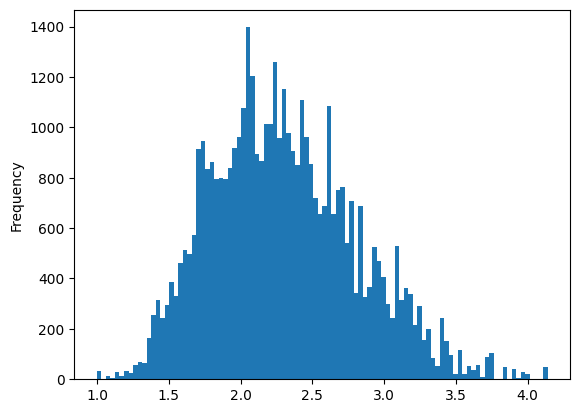

In [21]:
df["weight"].plot.hist(bins = 100)

In [22]:
train_df[(train_df["area_code"] == 13101) & (train_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
25,2007,2.066290e+06,0.066087,1.338686
134,2008,2.138766e+06,0.078330,1.067273
2386,2009,2.041136e+06,-0.012173,0.288051
4529,2010,1.823425e+06,-0.147440,-0.559345
6114,2011,1.730369e+06,-0.152252,-0.788732
9795,2012,1.778712e+06,-0.024521,0.003909
12159,2013,1.892848e+06,0.093898,0.801607
13392,2014,2.118136e+06,0.190826,1.427132
16708,2015,2.311121e+06,0.220975,1.562100
20248,2016,2.559555e+06,0.208399,1.391756


In [23]:
eval_df[(eval_df["area_code"] == 13101) & (eval_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
2715,2020,3.805970e+06,0.220832,1.336840
5079,2021,4.153525e+06,0.213891,1.068813
7625,2022,4.495858e+06,0.181264,0.889805


In [24]:
idx = 6302
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, asset_type, year = row["area_code"], row["asset_type"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["asset_type"] == asset_type)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window

Target: -0.6248064956039037


,area_code,area,year,asset_type,unit_price_median_smoothed_pct_chg,count_growth,yearly_price_growth,total_tax_growth,taxable_income_growth,taxable_income_per_taxpayer_growth,net_migration_ratio,new_dwellings_ratio,taxpayer_count_growth,unit_price_median_smoothed,count,total_traded_area,in_migrations,out_migrations,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,total_tax,new_dwellings,existing_dwellings,unit_price_median_smoothed_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,in_migrations_log_normalized_yearly,out_migrations_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,count_growth_normalized_yearly,yearly_price_growth_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,taxpayer_count_growth_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,metric_pct_chg_is_available,condo,land,log_population,weight
25734,45341,Miyazaki-ken Mimata-cho,2016,building,0.073355,0.400000,-0.017185,0.030277,0.030314,0.005532,0.001490,0.0,0.024646,40078.335336,28.0,11645.0,1122.0,1084.0,25510.0,9978.0,24385119.0,2443.888455,2070770.0,0.0,0.0,-0.287235,-0.307694,-0.033371,0.158319,0.067651,-0.036548,0.010557,-0.071213,-0.857545,-0.220223,0.0,0.0,0.441197,0.996401,-0.278254,0.788677,0.125171,-0.200505,0.563770,0.0,0.560141,1,1,0,1,1,0.0,0.0,4.406727,1.959259
27507,45341,Miyazaki-ken Mimata-cho,2017,building,-0.028690,-0.321429,-0.011706,0.042460,0.051498,0.020111,0.001213,0.0,0.030768,39609.191002,19.0,5990.0,1033.0,1002.0,25548.0,10285.0,25640897.0,2493.038114,2158695.0,0.0,0.0,-0.291953,-0.629442,-0.663636,0.114744,0.020324,-0.033389,0.024607,-0.050464,-0.777287,-0.205010,0.0,0.0,-0.265989,-0.988568,-0.161984,1.125643,0.770167,0.312081,0.546001,0.0,0.961280,1,1,0,1,1,0.0,0.0,4.407374,1.956202
31551,45341,Miyazaki-ken Mimata-cho,2018,building,-0.036242,-0.105263,-0.024827,0.019005,0.043637,0.026079,0.000117,0.0,0.017112,38625.827917,17.0,6435.0,1081.0,1078.0,25579.0,10461.0,26759801.0,2558.053819,2199721.0,0.0,0.0,-0.307918,-0.711897,-0.581166,0.148418,0.070385,-0.030275,0.031959,-0.034450,-0.678450,-0.195866,0.0,0.0,-0.285481,-0.397381,-0.312020,0.545066,0.522272,0.323688,0.466105,0.0,0.576955,1,1,0,1,1,0.0,0.0,4.407901,1.956114
35172,45341,Miyazaki-ken Mimata-cho,2019,building,-0.001640,0.176471,0.023777,0.022788,0.038049,0.026082,0.000352,0.0,0.011662,39544.238414,20.0,8255.0,1036.0,1027.0,25582.0,10583.0,27777981.0,2624.773788,2249848.0,0.0,0.0,-0.281664,-0.557277,-0.318970,0.132147,0.040494,-0.027750,0.038161,-0.016424,-0.549703,0.843100,0.0,0.0,-0.050681,0.358490,0.248075,0.361300,0.646865,0.475626,0.531578,0.0,0.528644,1,1,0,1,1,0.0,0.0,4.407951,1.956165
36432,45341,Miyazaki-ken Mimata-cho,2020,building,-0.030135,0.050000,-0.052660,0.012048,0.007908,-0.006549,-0.001290,0.0,0.014552,37461.846238,21.0,8180.0,948.0,981.0,25591.0,10737.0,27997645.0,2607.585452,2276954.0,0.0,0.0,-0.331456,-0.605244,-0.441465,0.089611,0.033229,-0.024754,0.046708,-0.013265,-0.617351,0.837026,0.0,0.0,-0.290600,-0.316090,-0.681581,0.435028,0.098706,-0.233158,0.259137,0.0,0.794158,1,1,0,1,1,0.0,0.0,4.408104,1.957086


In [25]:
log_normalize_columns = [
    metric,
    # "count",
    # "total_traded_area",
    # "in_migrations",
    # "out_migrations",
    # "population",
    # "taxpayer_count",
    # "taxable_income",
    # "taxable_income_per_taxpayer",
    # "total_tax",
    # "new_dwellings",
    # "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    # "count_growth",
    # "yearly_price_growth",
    # "total_tax_growth",
    # "taxable_income_growth",
    # "taxable_income_per_taxpayer_growth",
    # "net_migration_ratio",
    # "new_dwellings_ratio",
    # "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    # "migrations_is_available",
    # "taxable_income_is_available",
    # "dwellings_is_available",
    # "total_tax_is_available",
    # "metric_pct_chg_is_available"
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
)

final_columns = id_columns + feature_columns

In [26]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 1) (1,) [0.0398308] [4.136512]
1 (1, 1) (1,) [-0.28810291] [3.29911536]
2 (1, 1) (1,) [-1.10800607] [1.81622933]
3 (1, 1) (1,) [-0.20080112] [2.5089209]
0 torch.Size([5, 1]) torch.Size([1]) tensor([0.0398]) tensor([4.1365])
1 torch.Size([5, 1]) torch.Size([1]) tensor([-0.2881]) tensor([3.2991])
2 torch.Size([5, 1]) torch.Size([1]) tensor([-1.1080]) tensor([1.8162])
3 torch.Size([5, 1]) torch.Size([1]) tensor([-0.2008]) tensor([2.5089])


In [27]:
BATCH_SIZE = 256

In [28]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# Building the Transformer Model

In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [30]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [31]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 1]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.0178799629211426


In [32]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 30

In [33]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [34]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

KeyboardInterrupt: 

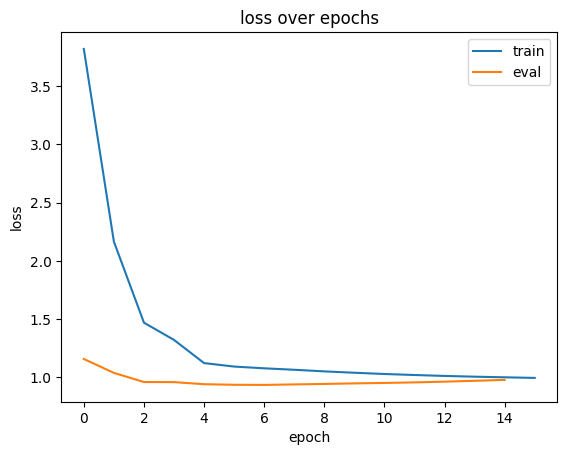

In [57]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

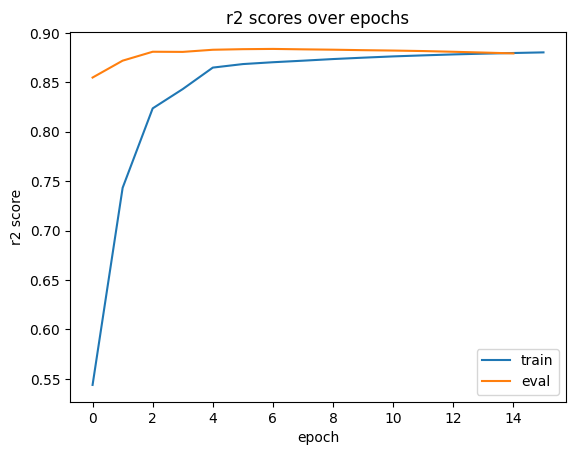

In [58]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [161]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.4022
Eval R2: 0.6050


In [162]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [163]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="year", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
18825,2022,46505,1.669664,0.506238,1.701291
17925,2022,20213,1.118304,0.451093,1.509740
17927,2022,7464,0.299596,0.097307,0.280852
17928,2022,21207,-0.979876,-0.271751,-1.001087
17929,2022,32201,-0.218079,0.034050,0.061126
...,...,...,...,...,...
15652,2020,13115,0.181602,0.066446,0.219392
15653,2020,1394,1.458018,0.189503,0.796317
15654,2020,15307,0.576230,-0.051788,-0.334918
15655,2020,44462,2.206206,0.795319,3.636536


In [164]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

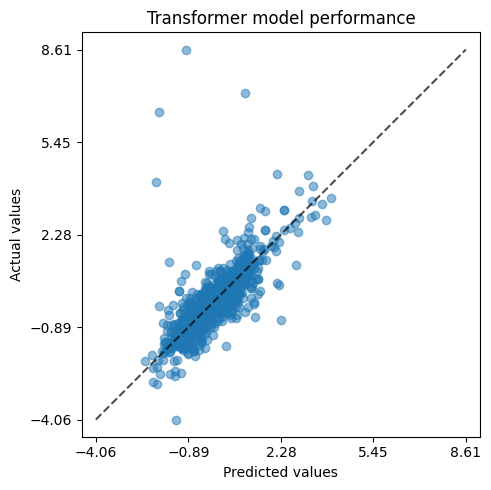

In [166]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

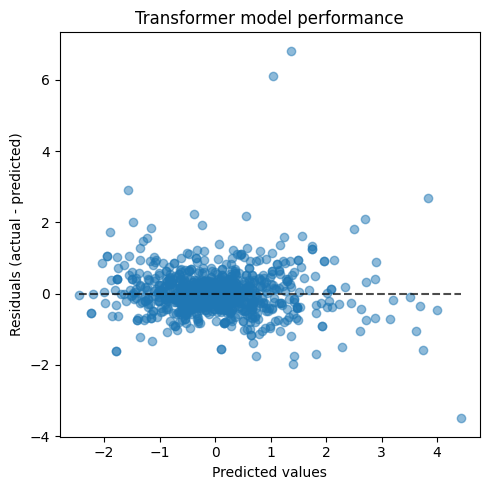

In [167]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()